In [1]:
import numpy as np
import pandas as pd

In [2]:
a=pd.read_csv('/Users/dean/Desktop/Web economics/newdata/train_index.csv')

In [4]:
b=pd.read_csv('/Users/dean/Desktop/Web economics/data/train.csv')

In [10]:
a["click"]=b["click"]

In [37]:
a

,Unnamed: 0,IP,adexchange,creative,domain,keypage,slotformat,slotheight,slotid,slotvisibility,...,tag68,click,weekday,hour,region,city,slotprice,bidprice,payprice,advertiser
0,0,1,1,1,1,1,1,1,1,1,...,0,0,1,14,80,85,5,300,54,1458
1,1,2,1,2,2,2,1,2,2,1,...,0,0,2,20,94,95,5,249,42,3476
2,2,3,2,3,3,1,2,3,3,2,...,0,0,5,9,216,217,0,300,76,1458
3,3,4,1,4,4,3,1,4,4,2,...,0,0,2,20,216,221,162,238,182,3427
4,4,5,2,5,5,4,2,4,5,2,...,0,0,6,9,40,48,0,238,34,3476
5,5,6,2,6,6,5,2,2,6,1,...,0,0,3,22,3,6,0,227,99,3358
6,6,7,1,7,7,6,3,4,7,3,...,0,0,5,16,216,217,5,277,61,2259
7,7,8,3,8,8,6,3,4,8,4,...,0,0,0,21,216,220,0,294,39,2821
8,8,9,1,9,9,7,1,3,9,5,...,0,0,4,17,201,213,5,300,111,3386
9,9,10,4,10,10,1,1,4,10,2,...,0,0,0,17,55,57,31,300,30,1458


In [19]:
a.to_csv('new_test.csv', sep=',')

In [26]:
train=pd.read_csv('/Users/dean/Downloads/new_test.csv')

KeyboardInterrupt: 

In [25]:
del train['Unnamed: 0']

In [27]:
#############################################################################################################
#classic tinrtgu's code
#https://www.kaggle.com/c/avazu-ctr-prediction/forums/t/10927/beat-the-benchmark-with-less-than-1mb-of-memory
#modified by rcarson
#https://www.kaggle.com/jiweiliu
#############################################################################################################


from datetime import datetime
from csv import DictReader
from math import exp, log, sqrt
from random import random
import pickle

# TL; DR, the main training process starts on line: 250,
# you may want to start reading the code from there


##############################################################################
# parameters #################################################################
##############################################################################

# A, paths
train='/Users/dean/Desktop/Web economics/newdata/train_index.csv'
test='/Users/dean/Desktop/Web economics/newdata/val_index.csv'#'vali_100.tsv'
submission = 'ftrltrain.csv'  # path of to be outputted submission file

# B, model
alpha = .05  # learning rate
beta = 1.   # smoothing parameter for adaptive learning rate
L1 = 10.     # L1 regularization, larger value means more regularized
L2 = 0.     # L2 regularization, larger value means more regularized

# C, feature/hash trick
D = 2 ** 24             # number of weights to use
interaction = False     # whether to enable poly2 feature interactions

# D, training/validation
epoch = 1       # learn training data for N passes
#holdafter = 9   # data after date N (exclusive) are used as validation
holdout = None  # use every N training instance for holdout validation


##############################################################################
# class, function, generator definitions #####################################
##############################################################################

class ftrl_proximal(object):
    ''' Our main algorithm: Follow the regularized leader - proximal

        In short,
        this is an adaptive-learning-rate sparse logistic-regression with
        efficient L1-L2-regularization

        Reference:
        http://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf
    '''

    def __init__(self, alpha, beta, L1, L2, D, interaction):
        # parameters
        self.alpha = alpha
        self.beta = beta
        self.L1 = L1
        self.L2 = L2

        # feature related parameters
        self.D = D
        self.interaction = interaction

        # model
        # n: squared sum of past gradients
        # z: weights
        # w: lazy weights
        self.n = [0.] * D
        self.z = [random() for k in range(D)]#[0.] * D
        self.w = {}

    def _indices(self, x):
        ''' A helper generator that yields the indices in x

            The purpose of this generator is to make the following
            code a bit cleaner when doing feature interaction.
        '''

        # first yield index of the bias term
        yield 0

        # then yield the normal indices
        for index in x:
            yield index

        # now yield interactions (if applicable)
        if self.interaction:
            D = self.D
            L = len(x)

            x = sorted(x)
            for i in xrange(L):
                for j in xrange(i+1, L):
                    # one-hot encode interactions with hash trick
                    yield abs(hash(str(x[i]) + '_' + str(x[j]))) % D

    def predict(self, x):
        ''' Get probability estimation on x

            INPUT:
                x: features

            OUTPUT:
                probability of p(y = 1 | x; w)
        '''

        # parameters
        alpha = self.alpha
        beta = self.beta
        L1 = self.L1
        L2 = self.L2

        # model
        n = self.n
        z = self.z
        w = {}

        # wTx is the inner product of w and x
        wTx = 0.
        for i in self._indices(x):
            sign = -1. if z[i] < 0 else 1.  # get sign of z[i]

            # build w on the fly using z and n, hence the name - lazy weights
            # we are doing this at prediction instead of update time is because
            # this allows us for not storing the complete w
            if sign * z[i] <= L1:
                # w[i] vanishes due to L1 regularization
                w[i] = 0.
            else:
                # apply prediction time L1, L2 regularization to z and get w
                w[i] = (sign * L1 - z[i]) / ((beta + sqrt(n[i])) / alpha + L2)

            wTx += w[i]

        # cache the current w for update stage
        self.w = w

        # bounded sigmoid function, this is the probability estimation
        return 1. / (1. + exp(-max(min(wTx, 35.), -35.)))

    def update(self, x, p, y):
        ''' Update model using x, p, y

            INPUT:
                x: feature, a list of indices
                p: click probability prediction of our model
                y: answer

            MODIFIES:
                self.n: increase by squared gradient
                self.z: weights
        '''

        # parameter
        alpha = self.alpha

        # model
        n = self.n
        z = self.z
        w = self.w

        # gradient under logloss
        g = p - y

        # update z and n
        for i in self._indices(x):
            sigma = (sqrt(n[i] + g * g) - sqrt(n[i])) / alpha
            z[i] += g - sigma * w[i]
            n[i] += g * g


def logloss(p, y):
    ''' FUNCTION: Bounded logloss

        INPUT:
            p: our prediction
            y: real answer

        OUTPUT:
            logarithmic loss of p given y
    '''

    p = max(min(p, 1. - 10e-15), 10e-15)
    return -log(p) if y == 1. else -log(1. - p)


def data(path, D):
    ''' GENERATOR: Apply hash-trick to the original csv row
                   and for simplicity, we one-hot-encode everything

        INPUT:
            path: path to training or testing file
            D: the max index that we can hash to

        YIELDS:
            ID: id of the instance, mainly useless
            x: a list of hashed and one-hot-encoded 'indices'
               we only need the index since all values are either 0 or 1
            y: y = 1 if we have a click, else we have y = 0
    '''

    for t, row in enumerate(DictReader(open(path), delimiter=',')):
        # process id
        #print row
        
        try:
            #ID= row['Unnamed: 0']
            del row['Unnamed: 0']
            
        except:
            pass
        # process clicks
        y = 0.
        target='click'#'IsClick' 
        if target in row:
            if row[target] == '1':
                y = 1.
            del row[target]

        # extract date

        # turn hour really into hour, it was originally YYMMDDHH

        # build x
        x = []
        for key in row:
            value = row[key]

            # one-hot encode everything with hash trick
            index = abs(hash(key + '_' + value)) % D
            x.append(index)

        yield x, y


##############################################################################
# start training #############################################################
##############################################################################

start = datetime.now()

# initialize ourselves a learner
learner = ftrl_proximal(alpha, beta, L1, L2, D, interaction)

# start training
for e in range(epoch):
    loss = 0.
    count = 0
    for x, y in data(train, D):  # data is a generator

        p = learner.predict(x)
        loss += logloss(p, y)
        learner.update(x, p, y)
        count+=1
        if count%1000==0:
            #print count,loss/count
            print('%s\tencountered: %d\tcurrent logloss: %f' % (
                datetime.now(), count, loss/count))
        #if count>10000: # comment this out when you run it locally.
            #break


count=0
loss=0
#import pickle
#pickle.dump(learner,open('ftrl3.p','w'))
print ('write result')
##############################################################################
# start testing, and build Kaggle's submission file ##########################
##############################################################################
with open(submission, 'w') as outfile:
    outfile.write('target\n')
    for  x, y in data(train, D):
        count+=1
        p = learner.predict(x)
        loss += logloss(p, y)

        outfile.write('%s\n' % (str(p)))
        if count%1000==0:
            #print count,loss/count
            print('%s\tencountered: %d\tcurrent logloss: %f' % (
                datetime.now(), count, loss/count))

2017-04-15 10:55:33.256645	encountered: 1000	current logloss: 0.021437
2017-04-15 10:55:33.462648	encountered: 2000	current logloss: 0.014837
2017-04-15 10:55:33.684961	encountered: 3000	current logloss: 0.017384
2017-04-15 10:55:33.890010	encountered: 4000	current logloss: 0.013333
2017-04-15 10:55:34.121555	encountered: 5000	current logloss: 0.012361
2017-04-15 10:55:34.322751	encountered: 6000	current logloss: 0.011595
2017-04-15 10:55:34.516816	encountered: 7000	current logloss: 0.011097
2017-04-15 10:55:34.701015	encountered: 8000	current logloss: 0.009797
2017-04-15 10:55:34.917224	encountered: 9000	current logloss: 0.011267
2017-04-15 10:55:35.099861	encountered: 10000	current logloss: 0.010269
2017-04-15 10:55:35.284305	encountered: 11000	current logloss: 0.009404
2017-04-15 10:55:35.472073	encountered: 12000	current logloss: 0.008662
2017-04-15 10:55:35.664249	encountered: 13000	current logloss: 0.008023
2017-04-15 10:55:35.845725	encountered: 14000	current logloss: 0.008078
2

In [33]:
with open(submission, 'w') as outfile:
    outfile.write('target\n')
    for  x, y in data(test, D):
        count+=1
        p = learner.predict(x)
        loss += logloss(p, y)

        outfile.write('%s\n' % (str(p)))
        if count%1000==0:
            #print count,loss/count
            print('%s\tencountered: %d\tcurrent logloss: %f' % (
                datetime.now(), count, loss/count))

2017-04-14 22:11:26.866487	encountered: 300000	current logloss: 0.000811
2017-04-14 22:11:27.227044	encountered: 301000	current logloss: 0.000811
2017-04-14 22:11:27.584473	encountered: 302000	current logloss: 0.000811
2017-04-14 22:11:27.953703	encountered: 303000	current logloss: 0.000811
2017-04-14 22:11:28.333838	encountered: 304000	current logloss: 0.000811
2017-04-14 22:11:28.678777	encountered: 305000	current logloss: 0.000811
2017-04-14 22:11:29.013123	encountered: 306000	current logloss: 0.000811
2017-04-14 22:11:29.354975	encountered: 307000	current logloss: 0.000811
2017-04-14 22:11:29.702828	encountered: 308000	current logloss: 0.000811
2017-04-14 22:11:30.063573	encountered: 309000	current logloss: 0.000811
2017-04-14 22:11:30.408566	encountered: 310000	current logloss: 0.000811
2017-04-14 22:11:30.753638	encountered: 311000	current logloss: 0.000811
2017-04-14 22:11:31.097251	encountered: 312000	current logloss: 0.000811
2017-04-14 22:11:31.457099	encountered: 313000	curr

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import math
import seaborn as sns

In [43]:
from sklearn.metrics import roc_auc_score
a=pd.read_csv('/Users/dean/Desktop/Web economics/newdata/val_index.csv')
b =pd.read_csv('/Users/dean/Downloads/ftrl1sub.csv')
roc_auc_score(a["click"],b["target"])

0.79980585798085613

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(a["click"],b["target"]))

0.027398445729608725

In [25]:
test='/Users/dean/Desktop/Web economics/newdata/train_index.csv'#'vali_100.tsv'
submission = 'ftrltrain.csv'  # path of to be outputted submission file
with open(submission, 'w') as outfile:
    outfile.write('target\n')
    for  x, y in data(test, D):
        count+=1
        p = learner.predict(x)
        loss += logloss(p, y)

        outfile.write('%s\n' % (str(p)))
        if count%1000==0:
            #print count,loss/count
            print('%s\tencountered: %d\tcurrent logloss: %f' % (
                datetime.now(), count, loss/count))

NameError: name 'data' is not defined

In [4]:
import xgboost
from sklearn import model_selection, linear_model, svm
def fit_xgboost(X, y):
    param_test1 = {
        'max_depth': range(3, 10, 2),
        'min_child_weight': range(1, 6, 2)
    }
    xgb = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=140, max_depth=5,
                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective='binary:logistic', nthread=4, scale_pos_weight=1,
                                seed=27)

    #model = model_selection.GridSearchCV(xgb, param_grid=param_test1, pre_dispatch="1*n_jobs", scoring='roc_auc',
                                         #n_jobs=multiprocessing.cpu_count(), cv=3)
    # model = xgb  # TODO testing
    xgb.fit(X, y)
    return model

In [25]:
a=pd.read_csv('/Users/dean/Desktop/Web economics/newdata/train_index.csv')

In [35]:
a

,IP,adexchange,creative,domain,keypage,slotformat,slotheight,slotid,slotvisibility,slotwidth,...,tag68,click,weekday,hour,region,city,slotprice,bidprice,payprice,advertiser
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,14,80,85,5,300,54,1458
1,2,1,2,2,2,1,2,2,1,2,...,0,0,2,20,94,95,5,249,42,3476
2,3,2,3,3,1,2,3,3,2,3,...,0,0,5,9,216,217,0,300,76,1458
3,4,1,4,4,3,1,4,4,2,4,...,0,0,2,20,216,221,162,238,182,3427
4,5,2,5,5,4,2,4,5,2,5,...,0,0,6,9,40,48,0,238,34,3476
5,6,2,6,6,5,2,2,6,1,6,...,0,0,3,22,3,6,0,227,99,3358
6,7,1,7,7,6,3,4,7,3,4,...,0,0,5,16,216,217,5,277,61,2259
7,8,3,8,8,6,3,4,8,4,7,...,0,0,0,21,216,220,0,294,39,2821
8,9,1,9,9,7,1,3,9,5,3,...,0,0,4,17,201,213,5,300,111,3386
9,10,4,10,10,1,1,4,10,2,8,...,0,0,0,17,55,57,31,300,30,1458


In [27]:
del a["Unnamed: 0"]

In [28]:
y = a["click"]

In [29]:
a

,IP,adexchange,creative,domain,keypage,slotformat,slotheight,slotid,slotvisibility,slotwidth,...,tag68,click,weekday,hour,region,city,slotprice,bidprice,payprice,advertiser
0,1,1,1,1,1,1,1,1,1,1,...,0,0,1,14,80,85,5,300,54,1458
1,2,1,2,2,2,1,2,2,1,2,...,0,0,2,20,94,95,5,249,42,3476
2,3,2,3,3,1,2,3,3,2,3,...,0,0,5,9,216,217,0,300,76,1458
3,4,1,4,4,3,1,4,4,2,4,...,0,0,2,20,216,221,162,238,182,3427
4,5,2,5,5,4,2,4,5,2,5,...,0,0,6,9,40,48,0,238,34,3476
5,6,2,6,6,5,2,2,6,1,6,...,0,0,3,22,3,6,0,227,99,3358
6,7,1,7,7,6,3,4,7,3,4,...,0,0,5,16,216,217,5,277,61,2259
7,8,3,8,8,6,3,4,8,4,7,...,0,0,0,21,216,220,0,294,39,2821
8,9,1,9,9,7,1,3,9,5,3,...,0,0,4,17,201,213,5,300,111,3386
9,10,4,10,10,1,1,4,10,2,8,...,0,0,0,17,55,57,31,300,30,1458


In [30]:
del a["click"]

In [31]:
X = a

In [13]:
xgbmodel = fit_xgboost(X, y)

NameError: name 'model' is not defined

In [23]:
xgb = xgboost.XGBClassifier(learning_rate=0.05, n_estimators=140, max_depth=5,
                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                objective='multi:softprob', nthread=4, scale_pos_weight=1,
                                seed=27)

In [24]:
xgbmodel = xgb.fit(X, y)

XGBoostError: b'value 0 for Parameter num_class should be greater equal to 1'

In [32]:
b=pd.read_csv('/Users/dean/Desktop/Web economics/newdata/val_index.csv')

In [33]:
del b["Unnamed: 0"]

In [34]:
f = b["click"]
del b["click"]

In [22]:
sum(xgbmodel.predict(b)==0)

299714

In [35]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X, y)

GaussianNB(priors=None)

In [36]:
NB_Prob = []
clf.predict_proba(b)

array([[  9.99194909e-01,   8.05091216e-04],
       [  9.98420679e-01,   1.57932132e-03],
       [  9.99138621e-01,   8.61378905e-04],
       ..., 
       [  9.99473904e-01,   5.26096125e-04],
       [  9.99540446e-01,   4.59553585e-04],
       [  9.99420498e-01,   5.79502431e-04]])

In [37]:
NB_Prob = []
NB_raw = clf.predict_proba(b)
for i in NB_raw:
    NB_Prob.append(i[1])

In [38]:
len(NB_Prob)

299749

In [39]:
len(f)

299749

In [40]:
from sklearn.metrics import roc_auc_score
roc_auc_score(f,NB_Prob)

0.63906126966064825

In [4]:
v =pd.read_csv('/Users/dean/Downloads/ftrl1sub.csv')

In [60]:
list(v["target"])

[0.00077930005905358182,
 0.0058254762262993261,
 0.0019642521999112253,
 0.0015766935206085356,
 0.00084401600512660428,
 0.00087395650578113849,
 0.00095521627917696567,
 0.00070394984961834653,
 0.00038917093783194073,
 0.0011692572296481769,
 0.0014686162298958841,
 0.0013567243376997053,
 0.0005172787947132463,
 0.001931749829168664,
 0.0004725154511980537,
 0.00034470840949373118,
 0.0011958672635958491,
 0.00062036904590186169,
 0.0006143236840847673,
 0.00078168094669357627,
 0.00029010104659823413,
 0.0006627904589583878,
 0.00043152167812774783,
 0.00057001647049450589,
 0.00077028776349698431,
 0.00017276602821702649,
 0.00043381812090789241,
 0.00049333968113186573,
 0.00042011035084280898,
 0.00041085267214439289,
 0.00036806487529453415,
 0.00053004922315376217,
 0.00026036617287987203,
 0.00057780801138775323,
 0.0020162558756596162,
 0.0009954934113195577,
 0.0004811985496988824,
 0.00019725928882809399,
 0.0002224053975396397,
 0.00031687912359832401,
 0.00060256736117

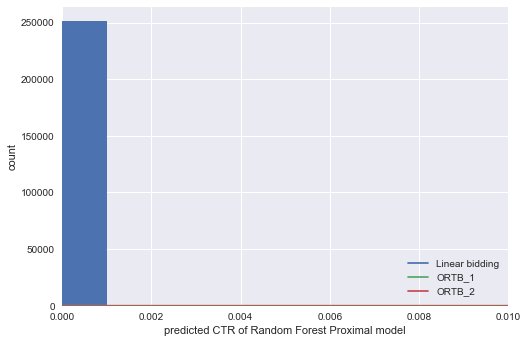

In [168]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(RF,bins=1000) #bins=100
plt.xlabel("predicted CTR of Random Forest Proximal model")
plt.ylabel("count")
#plt.axvline(x=validation_avg_ctr, color='r')
plt.xlim(0, 0.01)
plt.show()
#plt.savefig('FTRL_Dist_VAL.png',dpi=400)

In [3]:
w =pd.read_csv('/Users/dean/Downloads/ftrltrain.csv')

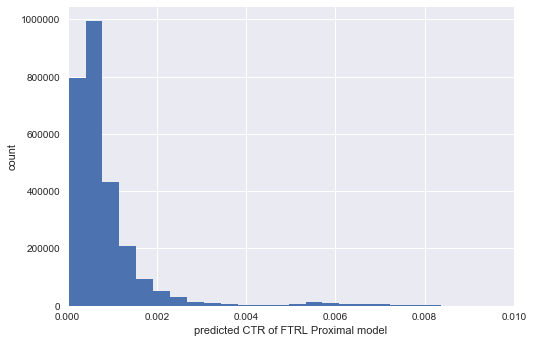

In [77]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(list(w["target"]),bins=1000) #bins=100
plt.xlabel("predicted CTR of FTRL Proximal model")
plt.ylabel("count")
#plt.axvline(x=validation_avg_ctr, color='r')
plt.xlim(0, 0.01)
plt.show()
#plt.savefig('FTRL_Dist_Train.png',dpi=400)

In [82]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(list(NB_Prob),bins=1000) #bins=100
plt.xlabel("predicted CTR of FTRL Proximal model")
plt.ylabel("count")
#plt.axvline(x=validation_avg_ctr, color='r')
plt.xlim(0, 0.01)
#plt.show()
plt.savefig('NB_DISTR.png',dpi=400)

In [45]:
from sklearn.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(f,NB_Prob))

0.0276217656828474

In [41]:
from sklearn.metrics import roc_curve
fpr_NB, tpr_NB, TH = roc_curve(f, NB_Prob)
fpr_FTRL, tpr_FTRL, THF = roc_curve(f, list(v["target"]))


In [44]:
plt.plot(fpr_NB, tpr_NB, color='C0',label='Naive Bayes ROC' )
plt.plot(fpr_FTRL,tpr_FTRL,color='C1',label='FTRL Proximal ROC')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('ROC_Mingda.png',dpi=400)

In [5]:
validation=pd.read_csv("/Users/dean/Desktop/Web economics/newdata/val_index.csv")

In [6]:
l =['IP', 'adexchange', 'creative', 'domain', 'keypage',
       'slotformat', 'slotheight', 'slotid', 'slotvisibility', 'slotwidth',
       'url', 'useragent', 'userid', 'tag0', 'tag1', 'tag2', 'tag3', 'tag4',
       'tag5', 'tag6', 'tag7', 'tag8', 'tag9', 'tag10', 'tag11', 'tag12',
       'tag13', 'tag14', 'tag15', 'tag16', 'tag17', 'tag18', 'tag19', 'tag20',
       'tag21', 'tag22', 'tag23', 'tag24', 'tag25', 'tag26', 'tag27', 'tag28',
       'tag29', 'tag30', 'tag31', 'tag32', 'tag33', 'tag34', 'tag35', 'tag36',
       'tag37', 'tag38', 'tag39', 'tag40', 'tag41', 'tag42', 'tag43', 'tag44',
       'tag45', 'tag46', 'tag47', 'tag48', 'tag49', 'tag50', 'tag51', 'tag52',
       'tag53', 'tag54', 'tag55', 'tag56', 'tag57', 'tag58', 'tag59', 'tag60',
       'tag61', 'tag62', 'tag63', 'tag64', 'tag65', 'tag66', 'tag67', 'tag68',
        'weekday', 'hour', 'region', 'city', 'slotprice', 'bidprice',
       'payprice', 'advertiser']
validation_data=validation[l]
validation_click=validation['click']

In [7]:
validation_click.value_counts()

0    299523
1       226
Name: click, dtype: int64

In [8]:
val_avgCTR=sum(validation['click'])/len(validation)
val_avgCTR

0.00075396415000550463

In [9]:
len(NB_Prob)

NameError: name 'NB_Prob' is not defined

In [104]:
mingdaclicks_underbudget=[validation_budget(i * (mingdalist/val_avgCTR),6250)[4] for i in range (0,300)]

ValueError: Wrong number of items passed 299749, placement implies 2697738

In [110]:
NB_6250_Lin=[validation_budget(i * (NB_Prob/val_avgCTR),6250) for i in range (0,300)]

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars
/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in double_scalars


In [113]:

NB_6250_Lin_clicks = []
for i in range(0,300):
    NB_6250_Lin_clicks.append(NB_6250_Lin[i][4])
NB_6250_Lin_clicks

[0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 12,
 12,
 12,
 13,
 13,
 15,
 16,
 16,
 16,
 16,
 18,
 18,
 18,
 20,
 20,
 22,
 23,
 24,
 26,
 27,
 27,
 27,
 27,
 27,
 28,
 29,
 30,
 31,
 33,
 34,
 35,
 35,
 39,
 40,
 42,
 43,
 48,
 54,
 55,
 56,
 60,
 65,
 67,
 65,
 66,
 65,
 68,
 67,
 68,
 65,
 65,
 65,
 70,
 76,
 75,
 74,
 74,
 75,
 72,
 72,
 73,
 73,
 73,
 71,
 71,
 69,
 72,
 73,
 73,
 72,
 75,
 77,
 77,
 79,
 79,
 80,
 78,
 77,
 78,
 79,
 78,
 78,
 78,
 78,
 79,
 78,
 77,
 77,
 76,
 74,
 75,
 75,
 75,
 75,
 74,
 73,
 73,
 73,
 73,
 73,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 72,
 73,
 73,
 73,
 73,
 72,
 72,
 72,
 72,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 71,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 70,
 

In [49]:
FTRL_6250_Lin=[validation_budget(i * (list(v["target"])/val_avgCTR),6250) for i in range (0,300)]#

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [50]:
FTRL_6250_Lin_clicks = []
for i in range(0,300):
    FTRL_6250_Lin_clicks.append(FTRL_6250_Lin[i][4])
#plt.plot(FTRL_6250_Lin_clicks)

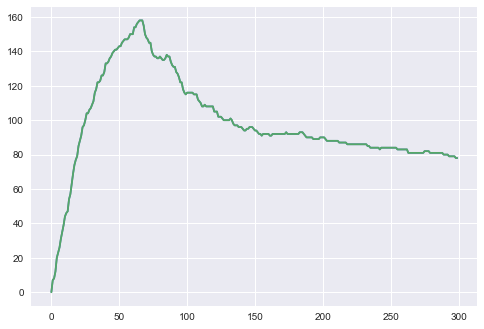

In [119]:
plt.plot(FTRL_6250_Lin_clicks)
plt.show()

In [120]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_2(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,6250))

In [123]:
FTRL_NON_2_6250 = best

In [125]:
len(FTRL_NON_2_6250)

299

In [127]:
FTRL_NON_2_6250 = best
FTRL_6250_NON2_clicks = []
for i in range(0,299):
    FTRL_6250_NON2_clicks.append(FTRL_NON_2_6250[i][4])

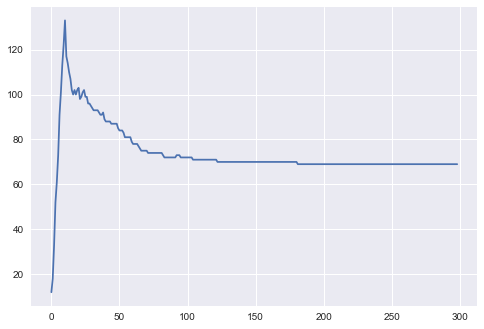

In [134]:
plt.plot(FTRL_6250_NON2_clicks)
plt.show()

In [129]:
best_1 = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best_1.append(validation_budget(bid_price_nonlinear,6250))

In [130]:
FTRL_NON_1_6250 = best_1

In [135]:
FTRL_6250_NON1_clicks = []
for i in range(0,299):
    FTRL_6250_NON1_clicks.append(FTRL_NON_1_6250[i][4])

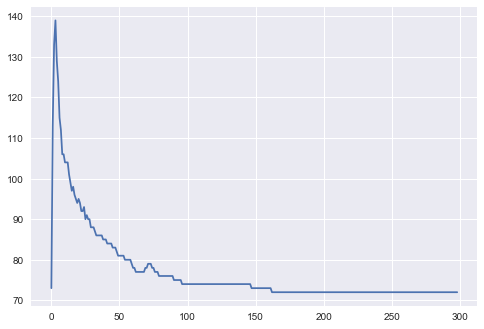

In [137]:
plt.plot(FTRL_6250_NON1_clicks)
plt.show()

In [92]:
def result(pre_bidprice):
    a=pd.DataFrame()
    a['val_click']=validation['click']  #[:j-1]
    a['payprice']=validation['payprice']
    a['pre_bidprice']=pd.Series(pre_bidprice, index=validation.index)
    a['bid_win'] = a['pre_bidprice']-a['payprice']
#    if a['bid_win'] >=0:
#        a['bid_win']=1
#    else:
#         a['bid_win']=0
     
    a = a[a['bid_win']>=0]
    
    pre_win_impression=len(a)
    pre_win_clicks=sum(a['val_click'])
    pre_CTR=pre_win_clicks/pre_win_impression #the clicked impression
    pre_spend=sum(a['payprice'])/1000
    pre_ACPM=pre_spend/pre_win_impression #cost per 1000 impressions
    pre_CPC= pre_win_clicks/pre_spend
    
    #l=["CTR", pre_CTR,"clicks",pre_win_clicks,"spend",pre_spend, "Avg_CPM",pre_ACPM, "Avg_CPC",pre_CPC]
    l=[pre_CTR,pre_win_clicks,pre_spend, pre_ACPM,pre_CPC]
    return l

In [10]:
def validation_budget(bidding,budget):
    new= validation.assign(bidding = bidding, diff= bidding -validation['payprice'])
    new= new[new['diff'] >= 0]
    cost= 0
    index= 0
    for pay in new.payprice:
        cost= pay + cost
        index += 1
        if cost/1000 >= budget:
            break
        
    
    clicks =sum(new['click'][:index])
    ctr= clicks/index
    spend = sum(new['payprice'][:index])/1000
    cpc = spend/clicks
    cpm = spend/index
    return [ctr,spend,cpc,cpm,clicks]

In [11]:
def ORTB_2(theta,c): # theta is the ctr, c is a constant
    lam=5.2*10**(-7) #lambda
    #optimal_bid_price=c*(((theta + np.sqrt(c**2*lam**2 + theta**2))/(c*lam))**(1/3)-((c*lam)/(theta + np.sqrt((c**2*(lam**2) + theta**2)))^(1/3))
    optimal_bid_price=c*(((theta + np.sqrt(c**2*lam**2 + theta**2))/(c*lam))**(1/3)-((c*lam)/(theta + np.sqrt((c**2*(lam**2) + theta**2)))**(1/3)))
    return optimal_bid_price

In [12]:
def ORTB_1(theta,c): # theta is the ctr, c is a constant
    lam=5.2*10**(-7) #lambda
    #optimal_bid_price=c*(((theta + np.sqrt(c**2*lam**2 + theta**2))/(c*lam))**(1/3)-((c*lam)/(theta + np.sqrt((c**2*(lam**2) + theta**2)))^(1/3))
    #optimal_bid_price=c*(((theta + np.sqrt(c**2*lam**2 + theta**2))/(c*lam))**(1/3)-((c*lam)/(theta + np.sqrt((c**2*(lam**2) + theta**2)))**(1/3)))
    optimal_bid_price = (np.sqrt((c*theta/lam)+c**2))-c
    return optimal_bid_price

In [139]:
RF =pd.read_csv("/Users/dean/Downloads/predictedrf.csv")

In [143]:
RF = list(RF['value'])

In [145]:
RF_6250_Lin=[validation_budget(i * (RF/val_avgCTR),6250) for i in range (0,300)]

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


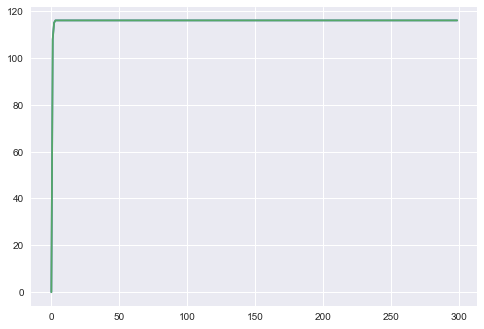

In [147]:
plt.plot(RF_6250_Lin_clicks)
plt.show()

In [146]:
RF_6250_Lin_clicks = []
for i in range(0,300):
    RF_6250_Lin_clicks.append(RF_6250_Lin[i][4])
plt.plot(RF_6250_Lin_clicks)

In [176]:
best_1_RF = []
for c in range(1,20,1):
   
    bid_price_nonlinear=[]
    for b in RF:
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best_1_RF.append(validation_budget(bid_price_nonlinear,6250))

In [177]:
RF_NON_1_6250 = best_1_RF

In [180]:
RF_6250_NON1_clicks = []
for i in range(0,19):
    RF_6250_NON1_clicks.append(RF_NON_1_6250[i][4])

In [182]:
RF

[0.20000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.20000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.10000000000000001,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.29999999999999999,
 0.0,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.20000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.20000000000000001,
 0.10000000000000001,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.20000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.20000000000000001,
 0.10000000000000001,
 0.0,
 0.0,
 0.0,
 0.0

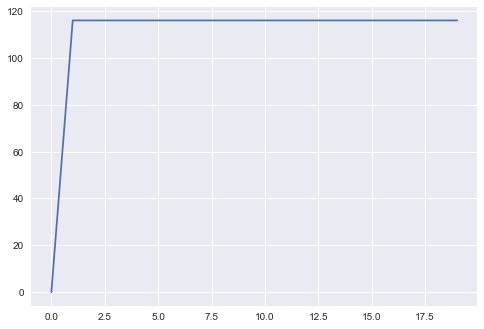

In [173]:
plt.plot(RF_6250_NON1_clicks)
plt.show()

In [204]:
best_2_RF = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in RF:
        
        bid_price_nonlinear.append(ORTB_2(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best_2_RF.append(validation_budget(bid_price_nonlinear,6250))

In [205]:
RF_NON_2_6250 = best_2_RF

In [206]:
RF_6250_NON2_clicks = []
for i in range(299):
    RF_6250_NON2_clicks.append(RF_NON_2_6250[i][4])

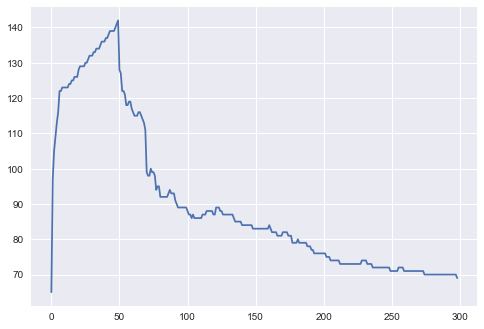

In [207]:
plt.plot(RF_6250_NON2_clicks)
plt.show()

[0.0026424757546039011, 1923.037, 19.825123711340208, 0.052387408739239402, 97]

In [191]:
best_2_RF

[[0.0022985254075462355,
  1102.961,
  16.968630769230771,
  0.03900282895434775,
  65],
 [0.0026424757546039011,
  1923.037,
  19.825123711340208,
  0.052387408739239402,
  97],
 [0.0025318897542861278,
  2567.0859999999998,
  24.448438095238092,
  0.061900749921631977,
  105],
 [0.0024440557872550338,
  3124.2710000000002,
  28.663036697247708,
  0.070054060720211669,
  109],
 [0.0023779961699530714,
  3512.0,
  31.079646017699115,
  0.073907279193585723,
  113],
 [0.00216858910844815,
  3861.7849999999999,
  33.291249999999998,
  0.072195042156624478,
  116],
 [0.0021875952590148648,
  4062.4160000000002,
  33.298491803278687,
  0.072843622801197799,
  122],
 [0.0021272514864605673,
  4190.893,
  34.351581967213114,
  0.073074453802026124,
  122],
 [0.0021048668628927372,
  4238.2020000000002,
  34.456926829268298,
  0.072527243480046549,
  123],
 [0.0020679915262786239,
  4247.5799999999999,
  34.533170731707315,
  0.071414304448703725,
  123],
 [0.0019984402417625269,
  4268.27999

In [167]:
plt.plot( FTRL_6250_Lin_clicks, color='C0',label='Linear bidding' )
plt.plot(FTRL_6250_NON1_clicks,color='C1',label='ORTB_1')
plt.plot(FTRL_6250_NON2_clicks,color='C2',label='ORTB_2')

plt.xlabel('Base Bid/C value')
plt.ylabel('Clicks')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('FTRL_BID_CLICKS.png',dpi=400)

In [210]:
FTRL_6250_NON1_CTR = []
for i in range(0,299):
    FTRL_6250_NON1_CTR.append(FTRL_NON_1_6250[i][0])

FTRL_6250_NON1_Spend = []
for i in range(0,299):
    FTRL_6250_NON1_Spend.append(FTRL_NON_1_6250[i][1])

FTRL_6250_NON1_CPC = []
for i in range(0,299):
    FTRL_6250_NON1_CPC.append(FTRL_NON_1_6250[i][2])

FTRL_6250_NON1_CPM = []
for i in range(0,299):
    FTRL_6250_NON1_CPM.append(FTRL_NON_1_6250[i][3])

FTRL_6250_NON2_CTR = []
for i in range(0,299):
    FTRL_6250_NON2_CTR.append(FTRL_NON_2_6250[i][0])

FTRL_6250_NON2_Spend = []
for i in range(0,299):
    FTRL_6250_NON2_Spend.append(FTRL_NON_2_6250[i][1])

FTRL_6250_NON2_CPC = []
for i in range(0,299):
    FTRL_6250_NON2_CPC.append(FTRL_NON_2_6250[i][2])

FTRL_6250_NON2_CPM = []
for i in range(0,299):
    FTRL_6250_NON2_CPM.append(FTRL_NON_2_6250[i][3])

FTRL_6250_Lin_CTR = []
for i in range(0,300):
    FTRL_6250_Lin_CTR.append(FTRL_6250_Lin[i][0])

FTRL_6250_Lin_Spend = []
for i in range(0,300):
    FTRL_6250_Lin_Spend.append(FTRL_6250_Lin[i][1])
FTRL_6250_Lin_CPC = []
for i in range(0,300):
    FTRL_6250_Lin_CPC.append(FTRL_6250_Lin[i][2])
FTRL_6250_Lin_CPM = []
for i in range(0,300):
    FTRL_6250_Lin_CPM.append(FTRL_6250_Lin[i][3])


In [51]:
FTRL_6250_Lin_CTR = []
for i in range(0,300):
    FTRL_6250_Lin_CTR.append(FTRL_6250_Lin[i][0])

In [52]:
FTRL_6250_Lin_CTR[65]

0.0011896873682308295

In [215]:
plt.plot( FTRL_6250_Lin_CTR, color='C0',label='Linear bidding' )
plt.plot(FTRL_6250_NON1_CTR,color='C1',label='ORTB_1')
plt.plot(FTRL_6250_NON2_CTR,color='C2',label='ORTB_2')

plt.xlabel('Base Bid/C value')
plt.ylabel('CTR')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('FTRL_BID_CTR.png',dpi=400)

In [234]:
plt.plot( FTRL_6250_Lin_CPC, color='C0',label='Linear bidding' )
plt.plot(FTRL_6250_NON1_CPC,color='C1',label='ORTB_1')
plt.plot(FTRL_6250_NON2_CPC,color='C2',label='ORTB_2')

plt.xlabel('Base Bid/C value')
plt.ylabel('CPC')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('FTRL_BID_CPC.png',dpi=400)

In [230]:
plt.plot( FTRL_6250_Lin_Spend, color='C0',label='Linear bidding' )
plt.plot(FTRL_6250_NON1_Spend,color='C1',label='ORTB_1')
plt.plot(FTRL_6250_NON2_Spend,color='C2',label='ORTB_2')

plt.xlabel('Base Bid/C value')
plt.ylabel('Spend')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('FTRL_BID_Spend.png',dpi=400)

In [228]:
plt.plot( FTRL_6250_Lin_CPM, color='C0',label='Linear bidding' )
plt.plot(FTRL_6250_NON1_CPM,color='C1',label='ORTB_1')
plt.plot(FTRL_6250_NON2_CPM,color='C2',label='ORTB_2')

plt.xlabel('Base Bid/C value')
plt.ylabel('CPM')
plt.legend(loc=4)
#plt.show()

#plt.tight_layout()
plt.savefig('FTRL_BID_CPM.png',dpi=400)

In [221]:
FTRL_6250_Lin_Spend

[0.0,
 5.8079999999999998,
 14.016,
 28.972999999999999,
 52.439999999999998,
 84.474999999999994,
 115.378,
 148.68100000000001,
 180.63900000000001,
 216.315,
 254.488,
 294.25,
 333.005,
 376.17899999999997,
 424.98200000000003,
 476.125,
 535.10699999999997,
 592.70100000000002,
 653.76499999999999,
 715.15599999999995,
 787.97299999999996,
 858.80700000000002,
 938.84900000000005,
 1021.395,
 1101.8150000000001,
 1188.9300000000001,
 1278.105,
 1369.2550000000001,
 1489.22,
 1599.2059999999999,
 1714.453,
 1824.7190000000001,
 1935.575,
 2037.5229999999999,
 2147.9099999999999,
 2266.0500000000002,
 2384.7579999999998,
 2511.2220000000002,
 2624.9090000000001,
 2748.3330000000001,
 2881.9369999999999,
 3005.2829999999999,
 3131.2069999999999,
 3249.712,
 3379.2249999999999,
 3501.1819999999998,
 3624.7020000000002,
 3748.8420000000001,
 3870.328,
 3997.6469999999999,
 4120.0569999999998,
 4241.826,
 4365.5510000000004,
 4491.1369999999997,
 4615.9589999999998,
 4744.5919999999996,

In [238]:
CModel = (list(w["target"]) + list(RF))/2

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [239]:
CModel = []
for a,b in list(w["target"]),list(RF):
    CModel.append((a+b)/2)

ValueError: too many values to unpack (expected 2)

In [240]:
len(RF)

299749

In [243]:
CModel = []
for i in range(len(RF)):
    CModel.append((list(w["target"])[i]+RF[i])/2)

KeyboardInterrupt: 

In [54]:
FTRL_12500_Lin=[validation_budget(i * (list(v["target"])/val_avgCTR),12500) for i in range (0,300)]#

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [55]:
FTRL_12500_Lin_clicks = []
for i in range(0,300):
    FTRL_12500_Lin_clicks.append(FTRL_12500_Lin[i][4])

FTRL_12500_Lin_CTR = []
for i in range(0,300):
    FTRL_12500_Lin_CTR.append(FTRL_12500_Lin[i][0])

In [62]:
FTRL_12500_Lin_CTR[118]

0.00091974601238460141

In [57]:
FTRL_3125_Lin=[validation_budget(i * (list(v["target"])/val_avgCTR),3125) for i in range (0,300)]#

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [58]:
FTRL_3125_Lin_clicks = []
for i in range(0,300):
    FTRL_3125_Lin_clicks.append(FTRL_3125_Lin[i][4])

FTRL_3125_Lin_CTR = []
for i in range(0,300):
    FTRL_3125_Lin_CTR.append(FTRL_3125_Lin[i][0])

In [66]:
max(FTRL_3125_Lin_clicks)
FTRL_3125_Lin_clicks.index(134)
FTRL_3125_Lin_CTR[42]


0.001596739790993911

In [59]:
FTRL_25000_Lin=[validation_budget(i * (list(v["target"])/val_avgCTR),25000) for i in range (0,300)]#

/Users/dean/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in double_scalars


In [60]:
FTRL_25000_Lin_clicks = []
for i in range(0,300):
    FTRL_25000_Lin_clicks.append(FTRL_25000_Lin[i][4])

FTRL_25000_Lin_CTR = []
for i in range(0,300):
    FTRL_25000_Lin_CTR.append(FTRL_25000_Lin[i][0])

In [69]:
max( FTRL_25000_Lin_clicks)
FTRL_25000_Lin_clicks.index(217)
FTRL_25000_Lin_CTR[295]

0.00079249431193598695

In [63]:
FTRL_6250_Lin_CTR[65]

0.0011896873682308295

In [ ]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_2(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,25000))

In [ ]:
FTRL_NON_2_25000 = best
FTRL_25000_NON2_clicks = []
for i in range(0,299):
    FTRL_25000_NON2_clicks.append(FTRL_NON_2_25000[i][4])
FTRL_25000_NON2_CTR = []
for i in range(0,299):
    FTRL_25000_NON2_CTR.append(FTRL_NON_2_25000[i][0])

In [265]:
FTRL_25000_NON2_clicks

[12,
 18,
 33,
 52,
 61,
 73,
 91,
 101,
 113,
 122,
 133,
 140,
 142,
 145,
 152,
 155,
 157,
 161,
 165,
 169,
 171,
 172,
 177,
 180,
 182,
 183,
 184,
 184,
 186,
 189,
 193,
 194,
 194,
 196,
 196,
 196,
 196,
 198,
 201,
 201,
 201,
 201,
 204,
 205,
 205,
 207,
 208,
 208,
 208,
 208,
 210,
 211,
 213,
 213,
 214,
 214,
 215,
 216,
 216,
 216,
 216,
 216,
 216,
 216,
 216,
 216,
 216,
 217,
 217,
 218,
 218,
 218,
 219,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 220,
 221,
 221,
 221,
 221,
 222,
 222,
 222,
 222,
 222,
 222,
 222,
 222,
 222,
 222,
 222,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 223,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 224,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,
 225,

In [83]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_2(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,12500))

In [84]:
FTRL_NON_2_12500 = best
FTRL_12500_NON2_clicks = []
for i in range(0,199):
    FTRL_12500_NON2_clicks.append(FTRL_NON_2_12500[i][4])
FTRL_12500_NON2_CTR = []
for i in range(0,199):
    FTRL_12500_NON2_CTR.append(FTRL_NON_2_12500[i][0])

In [89]:
max(FTRL_12500_NON2_clicks)
FTRL_12500_NON2_CTR[23]

0.00077270795502839705

In [14]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_2(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,3125))

In [15]:
FTRL_NON_2_3125 = best
FTRL_3125_NON2_clicks = []
for i in range(0,299):
    FTRL_3125_NON2_clicks.append(FTRL_NON_2_3125[i][4])
FTRL_3125_NON2_CTR = []
for i in range(0,299):
    FTRL_3125_NON2_CTR.append(FTRL_NON_2_3125[i][0])

In [73]:
max(FTRL_3125_NON2_clicks)
FTRL_3125_NON2_clicks.index(91)
FTRL_3125_NON2_CTR[6]

0.00086792308866168167

In [16]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,25000))

In [17]:
FTRL_NON_1_25000 = best
FTRL_25000_NON1_clicks = []
for i in range(0,299):
    FTRL_25000_NON1_clicks.append(FTRL_NON_1_25000[i][4])
FTRL_25000_NON1_CTR = []
for i in range(0,299):
    FTRL_25000_NON1_CTR.append(FTRL_NON_1_25000[i][0])

In [82]:
max(FTRL_25000_NON1_clicks)
FTRL_25000_NON1_clicks.index(222)
FTRL_25000_NON1_CTR[273]

0.00075959761855881754

In [18]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,12500))

In [19]:
FTRL_NON_1_12500 = best
FTRL_12500_NON1_clicks = []
for i in range(0,299):
    FTRL_12500_NON1_clicks.append(FTRL_NON_1_12500[i][4])
FTRL_12500_NON1_CTR = []
for i in range(0,299):
    FTRL_12500_NON1_CTR.append(FTRL_NON_1_12500[i][0])

In [20]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,12500))

In [21]:
FTRL_NON_1_12500 = best
FTRL_12500_NON1_clicks = []
for i in range(0,299):
    FTRL_12500_NON1_clicks.append(FTRL_NON_1_12500[i][4])
FTRL_12500_NON1_CTR = []
for i in range(0,299):
    FTRL_12500_NON1_CTR.append(FTRL_NON_1_12500[i][0])

In [79]:
max(FTRL_12500_NON1_clicks)
FTRL_12500_NON1_clicks.index(187)
FTRL_12500_NON1_CTR[11]

0.00082907343285170223

In [22]:
best = []
for c in range(1,300,1):
   
    bid_price_nonlinear=[]
    for b in list(v["target"]):
        
        bid_price_nonlinear.append(ORTB_1(b,c))
    #validation_budget(bid_price_nonlinear,6250)
    best.append(validation_budget(bid_price_nonlinear,3125))

In [23]:
FTRL_NON_1_3125 = best
FTRL_3125_NON1_clicks = []
for i in range(0,299):
    FTRL_3125_NON1_clicks.append(FTRL_NON_1_3125[i][4])
FTRL_3125_NON1_CTR = []
for i in range(0,299):
    FTRL_3125_NON1_CTR.append(FTRL_NON_1_3125[i][0])

In [76]:
max(FTRL_3125_NON1_clicks)
FTRL_3125_NON1_clicks.index(106)
FTRL_3125_NON1_CTR[1]

0.0010515560052776207